In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
import statsmodels.api as sm
import lightgbm as lgb

### Feature selection modules from sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [2]:
def unique_num(data, key):
    return len(set(data[key]))

## day of the week and time of day
def add_feature( data, time_key):
    data['day'] = [int(x.split(' ')[0].split('-')[2])%7 for x in  data[time_key]]
    data['hour'] = [float(x.split(' ')[1].split(':')[0]) for x in data[time_key]]
    return data

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
view_log=pd.read_csv('view_log.csv')
item_data=pd.read_csv('item_data.csv')

In [4]:
display(train_data.head(2))
n_click_train = len(train_data[train_data['is_click']==1])
n_noclick_train = len(train_data[train_data['is_click']==0])
print ('Number of unique users :- %s'%(len(np.unique(train_data['user_id']))))
print ('Number of clicks :- %s'%(n_click_train))
print ('Number of no click :- %s'%(n_noclick_train))
print ('----> Percentage of clicks to noclick in train data :- %f'%(n_click_train*100/n_noclick_train))
print ('---------------------------------')
print ('---------------------------------')

chars = [ch for ch in train_data['impression_id'][0] ]
print ('Length of impression id characters %s is same as length of data'%(len (chars)))
print (unique_num(train_data, 'impression_id'))
print ('----> each impression id encodes entire information of user_id, impression time, os version, is_4G and clicking data')

print ('---------------------------------')
print ('---------------------------------')
print ('impression times range from 15 nov to 13 dec which means ')
time_key = ['impression_time', 'server_time']
train_data = add_feature(train_data, time_key[0])
test_data = add_feature(test_data, time_key[0])
view_log = add_feature(view_log, time_key[1])


#print (unique_num(train_data, 'impression_time_int'))
train_data['os_version_num'] = np.zeros(len(train_data))
train_data['os_version_num'][train_data['os_version'] == 'intermediate'] = int(2)
train_data['os_version_num'][train_data['os_version'] == 'old'] = int(1)
train_data['os_version_num'][train_data['os_version'] == 'latest'] = int(3)

display(train_data.head(2))

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1


Number of unique users :- 74723
Number of clicks :- 10862
Number of no click :- 226747
----> Percentage of clicks to noclick in train data :- 4.790361
---------------------------------
---------------------------------
Length of impression id characters 32 is same as length of data
237609
----> each impression id encodes entire information of user_id, impression time, os version, is_4G and clicking data
---------------------------------
---------------------------------
impression times range from 15 nov to 13 dec which means 


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,day,hour,os_version_num
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,0.0,1.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,0.0,3.0


Index(['user_id', 'app_code', 'os_version', 'is_4G', 'is_click', 'day', 'hour',
       'os_version_num'],
      dtype='object')


,user_id,app_code,os_version,is_4G,is_click,day,hour,os_version_num
0,87862,422,old,0,0,1,0.0,1.0
1,63410,467,latest,1,1,1,0.0,3.0


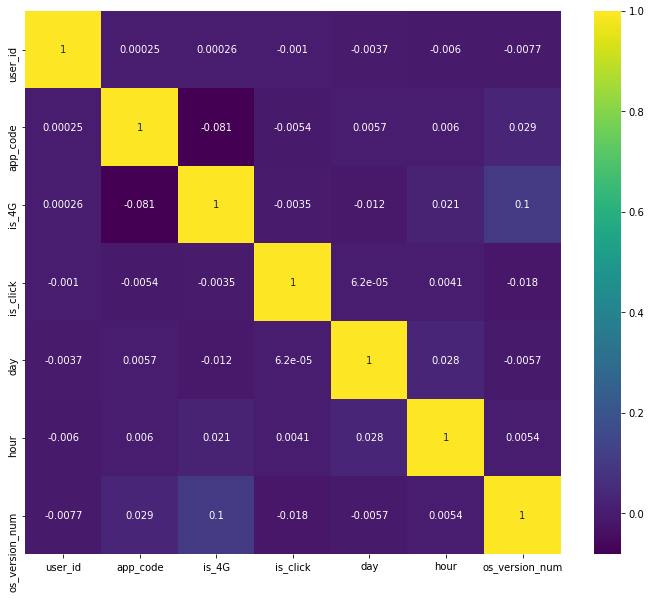

In [5]:
## identifying the features for modeling
df = pd.DataFrame(train_data)
x_y = df.drop('impression_id',  1)
x_y = x_y.drop ('impression_time', 1)

print (x_y.columns)
#x_y['']
plt.show()
display(x_y.head(2))
plt.figure(figsize=(12,10))
cor = x_y.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.viridis)
plt.show()

In [6]:
#Correlation with output variable
cor_target = abs(cor["is_click"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.001]
print (relevant_features)
print ('=============')
print (x_y[['os_version_num', 'is_4G']].corr())

print ('os version and is_4G are correlated makes sense because normally latest version are more likely to have 4G connection')


print ('==========================')
print (x_y[['os_version_num', 'app_code']].corr() )
print (x_y[['app_code', 'hour']].corr() )
print (x_y[['os_version_num', 'hour']].corr() )


print ('None of these features are correlated with each other,\
\nTherefore I believe the relevant features for traning should be :- ', 'app_code', 'hour', 'os_version_int' )
print ('we can get rid of 2 features user_id, and is_4G.... may be more testin required before gettin rid of these')

user_id           0.001035
app_code          0.005449
is_4G             0.003464
is_click          1.000000
hour              0.004081
os_version_num    0.017669
Name: is_click, dtype: float64
                os_version_num     is_4G
os_version_num        1.000000  0.101101
is_4G                 0.101101  1.000000
os version and is_4G are correlated makes sense because normally latest version are more likely to have 4G connection
                os_version_num  app_code
os_version_num        1.000000  0.028788
app_code              0.028788  1.000000
          app_code      hour
app_code  1.000000  0.005997
hour      0.005997  1.000000
                os_version_num      hour
os_version_num        1.000000  0.005387
hour                  0.005387  1.000000
None of these features are correlated with each other,
Therefore I believe the relevant features for traning should be :-  app_code hour os_version_int
we can get rid of 2 features user_id, and is_4G.... may be more testin required b

In [7]:
### AN attempt to understand user profiles using view_log
import warnings
warnings.filterwarnings('ignore')
display(view_log.head(2))
print ('=======================')
unique_devices = np.unique(view_log['device_type'])
for i in range(3):   
    print (len(view_log[view_log['device_type'] == unique_devices[i]]), '%s users'%(unique_devices[i]))
print ('device type does not matter')
print ('==========')


,server_time,device_type,session_id,user_id,item_id,day,hour
0,2018-10-15 08:58:00,android,112333,4557,32970,1,8.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1,8.0


3117737 android users
861 iphone users
24 web users
device type does not matter


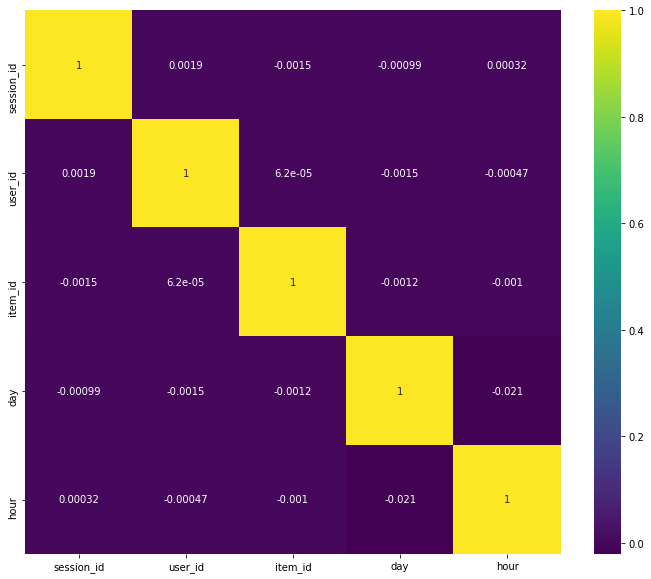

In [8]:
df_view = pd.DataFrame(view_log)
df_view = df_view.drop('server_time',1)
plt.figure(figsize=(12,10))
cor = df_view.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.viridis)
plt.show()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822


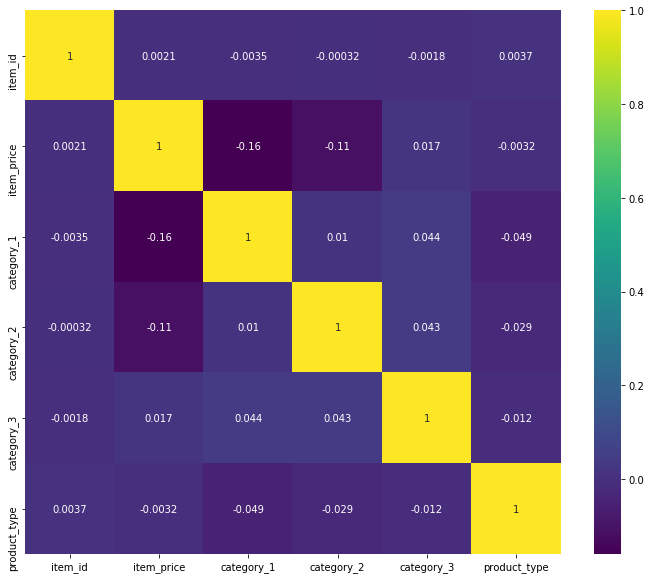

In [9]:
display(item_data.head(2))

df_item = pd.DataFrame(item_data)

plt.figure(figsize=(12,10))
cor = df_item.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.viridis)
plt.show()

Text(0.5, 1.0, 'Trends of clicks by hour of day')

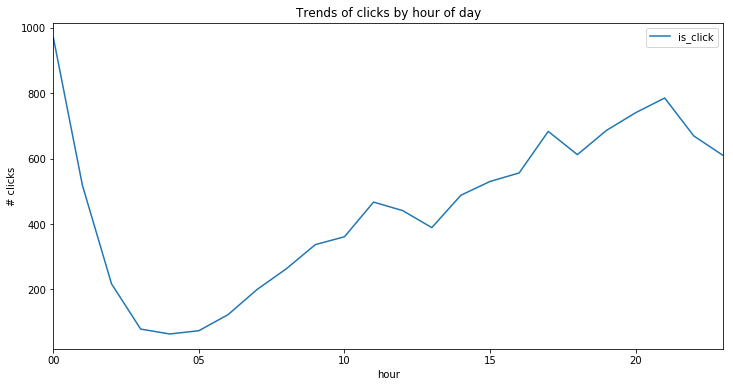

In [10]:
train_data['hour'] = train_data.impression_time.apply(lambda x: x.split(" ")[1].split(':')[0])
train_data.groupby('hour').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('# clicks')
plt.title('Trends of clicks by hour of day')

In [12]:
display(train_data.head())
train = train_data
X_train = train.loc[:, ['user_id', 'is_4G', 'day',  'app_code', 'os_version_num']]# train.columns != ['is_click', 'impression_time']]
y_target = train.is_click.values
#create lightgbm dataset
msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_target[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_target[~msk], reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'auc'},
    'num_leaves': 31, # defauly leaves(31) amount for each tree
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 1
}
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=1500)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,day,hour,os_version_num
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,00,1.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,00,3.0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,00,2.0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,00,3.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,00,3.0


Start training...
[1]	valid_0's auc: 0.642379
Training until validation scores don't improve for 1500 rounds.
[2]	valid_0's auc: 0.663419
[3]	valid_0's auc: 0.663305
[4]	valid_0's auc: 0.672439
[5]	valid_0's auc: 0.673515
[6]	valid_0's auc: 0.67489
[7]	valid_0's auc: 0.676012
[8]	valid_0's auc: 0.676101
[9]	valid_0's auc: 0.676883
[10]	valid_0's auc: 0.677805
[11]	valid_0's auc: 0.678663
[12]	valid_0's auc: 0.677967
[13]	valid_0's auc: 0.678162
[14]	valid_0's auc: 0.678469
[15]	valid_0's auc: 0.678336
[16]	valid_0's auc: 0.67827
[17]	valid_0's auc: 0.678016
[18]	valid_0's auc: 0.678787
[19]	valid_0's auc: 0.679404
[20]	valid_0's auc: 0.680146
[21]	valid_0's auc: 0.680094
[22]	valid_0's auc: 0.680735
[23]	valid_0's auc: 0.680729
[24]	valid_0's auc: 0.680634
[25]	valid_0's auc: 0.680247
[26]	valid_0's auc: 0.680072
[27]	valid_0's auc: 0.680703
[28]	valid_0's auc: 0.681293
[29]	valid_0's auc: 0.681749
[30]	valid_0's auc: 0.681996
[31]	valid_0's auc: 0.682616
[32]	valid_0's auc: 0.682869
[

[280]	valid_0's auc: 0.688278
[281]	valid_0's auc: 0.688388
[282]	valid_0's auc: 0.688669
[283]	valid_0's auc: 0.688929
[284]	valid_0's auc: 0.689082
[285]	valid_0's auc: 0.68907
[286]	valid_0's auc: 0.689067
[287]	valid_0's auc: 0.689081
[288]	valid_0's auc: 0.689186
[289]	valid_0's auc: 0.689078
[290]	valid_0's auc: 0.688959
[291]	valid_0's auc: 0.688998
[292]	valid_0's auc: 0.689026
[293]	valid_0's auc: 0.689097
[294]	valid_0's auc: 0.689234
[295]	valid_0's auc: 0.689214
[296]	valid_0's auc: 0.689158
[297]	valid_0's auc: 0.689272
[298]	valid_0's auc: 0.689302
[299]	valid_0's auc: 0.689327
[300]	valid_0's auc: 0.689353
[301]	valid_0's auc: 0.689553
[302]	valid_0's auc: 0.689713
[303]	valid_0's auc: 0.689817
[304]	valid_0's auc: 0.689738
[305]	valid_0's auc: 0.689699
[306]	valid_0's auc: 0.689694
[307]	valid_0's auc: 0.689701
[308]	valid_0's auc: 0.689577
[309]	valid_0's auc: 0.68964
[310]	valid_0's auc: 0.68951
[311]	valid_0's auc: 0.68965
[312]	valid_0's auc: 0.689804
[313]	valid_0'

[556]	valid_0's auc: 0.687459
[557]	valid_0's auc: 0.6875
[558]	valid_0's auc: 0.68751
[559]	valid_0's auc: 0.687426
[560]	valid_0's auc: 0.687386
[561]	valid_0's auc: 0.687394
[562]	valid_0's auc: 0.687211
[563]	valid_0's auc: 0.687124
[564]	valid_0's auc: 0.6872
[565]	valid_0's auc: 0.687173
[566]	valid_0's auc: 0.687147
[567]	valid_0's auc: 0.687179
[568]	valid_0's auc: 0.687161
[569]	valid_0's auc: 0.687044
[570]	valid_0's auc: 0.687043
[571]	valid_0's auc: 0.687078
[572]	valid_0's auc: 0.687133
[573]	valid_0's auc: 0.687232
[574]	valid_0's auc: 0.687247
[575]	valid_0's auc: 0.687234
[576]	valid_0's auc: 0.687255
[577]	valid_0's auc: 0.68736
[578]	valid_0's auc: 0.687381
[579]	valid_0's auc: 0.687339
[580]	valid_0's auc: 0.687567
[581]	valid_0's auc: 0.687679
[582]	valid_0's auc: 0.687652
[583]	valid_0's auc: 0.687538
[584]	valid_0's auc: 0.687512
[585]	valid_0's auc: 0.687582
[586]	valid_0's auc: 0.687503
[587]	valid_0's auc: 0.68761
[588]	valid_0's auc: 0.687651
[589]	valid_0's a

[836]	valid_0's auc: 0.686938
[837]	valid_0's auc: 0.686866
[838]	valid_0's auc: 0.686641
[839]	valid_0's auc: 0.686619
[840]	valid_0's auc: 0.686412
[841]	valid_0's auc: 0.686418
[842]	valid_0's auc: 0.686401
[843]	valid_0's auc: 0.686521
[844]	valid_0's auc: 0.686612
[845]	valid_0's auc: 0.686572
[846]	valid_0's auc: 0.68653
[847]	valid_0's auc: 0.686647
[848]	valid_0's auc: 0.686694
[849]	valid_0's auc: 0.686823
[850]	valid_0's auc: 0.686996
[851]	valid_0's auc: 0.687155
[852]	valid_0's auc: 0.687287
[853]	valid_0's auc: 0.687227
[854]	valid_0's auc: 0.687299
[855]	valid_0's auc: 0.687216
[856]	valid_0's auc: 0.687246
[857]	valid_0's auc: 0.687294
[858]	valid_0's auc: 0.687203
[859]	valid_0's auc: 0.687176
[860]	valid_0's auc: 0.687202
[861]	valid_0's auc: 0.687218
[862]	valid_0's auc: 0.687272
[863]	valid_0's auc: 0.6872
[864]	valid_0's auc: 0.687262
[865]	valid_0's auc: 0.687192
[866]	valid_0's auc: 0.687062
[867]	valid_0's auc: 0.686945
[868]	valid_0's auc: 0.686919
[869]	valid_0

[1109]	valid_0's auc: 0.685244
[1110]	valid_0's auc: 0.685297
[1111]	valid_0's auc: 0.685352
[1112]	valid_0's auc: 0.685303
[1113]	valid_0's auc: 0.685453
[1114]	valid_0's auc: 0.685532
[1115]	valid_0's auc: 0.685525
[1116]	valid_0's auc: 0.685817
[1117]	valid_0's auc: 0.685933
[1118]	valid_0's auc: 0.686024
[1119]	valid_0's auc: 0.685987
[1120]	valid_0's auc: 0.685913
[1121]	valid_0's auc: 0.685904
[1122]	valid_0's auc: 0.685866
[1123]	valid_0's auc: 0.685602
[1124]	valid_0's auc: 0.6855
[1125]	valid_0's auc: 0.685528
[1126]	valid_0's auc: 0.685579
[1127]	valid_0's auc: 0.685623
[1128]	valid_0's auc: 0.685563
[1129]	valid_0's auc: 0.685562
[1130]	valid_0's auc: 0.685499
[1131]	valid_0's auc: 0.685168
[1132]	valid_0's auc: 0.685076
[1133]	valid_0's auc: 0.685178
[1134]	valid_0's auc: 0.68515
[1135]	valid_0's auc: 0.685027
[1136]	valid_0's auc: 0.684835
[1137]	valid_0's auc: 0.684781
[1138]	valid_0's auc: 0.684835
[1139]	valid_0's auc: 0.684619
[1140]	valid_0's auc: 0.684582
[1141]	vali

[1381]	valid_0's auc: 0.6809
[1382]	valid_0's auc: 0.680981
[1383]	valid_0's auc: 0.681006
[1384]	valid_0's auc: 0.680871
[1385]	valid_0's auc: 0.680918
[1386]	valid_0's auc: 0.681034
[1387]	valid_0's auc: 0.681035
[1388]	valid_0's auc: 0.68098
[1389]	valid_0's auc: 0.681061
[1390]	valid_0's auc: 0.681049
[1391]	valid_0's auc: 0.681039
[1392]	valid_0's auc: 0.681065
[1393]	valid_0's auc: 0.680975
[1394]	valid_0's auc: 0.680938
[1395]	valid_0's auc: 0.680885
[1396]	valid_0's auc: 0.680774
[1397]	valid_0's auc: 0.680588
[1398]	valid_0's auc: 0.680559
[1399]	valid_0's auc: 0.68056
[1400]	valid_0's auc: 0.680421
[1401]	valid_0's auc: 0.680429
[1402]	valid_0's auc: 0.680551
[1403]	valid_0's auc: 0.680851
[1404]	valid_0's auc: 0.680986
[1405]	valid_0's auc: 0.680918
[1406]	valid_0's auc: 0.680976
[1407]	valid_0's auc: 0.680967
[1408]	valid_0's auc: 0.68105
[1409]	valid_0's auc: 0.681084
[1410]	valid_0's auc: 0.68111
[1411]	valid_0's auc: 0.681189
[1412]	valid_0's auc: 0.681066
[1413]	valid_0

[1647]	valid_0's auc: 0.678715
[1648]	valid_0's auc: 0.678655
[1649]	valid_0's auc: 0.678554
[1650]	valid_0's auc: 0.678575
[1651]	valid_0's auc: 0.678494
[1652]	valid_0's auc: 0.678522
[1653]	valid_0's auc: 0.678408
[1654]	valid_0's auc: 0.678471
[1655]	valid_0's auc: 0.678505
[1656]	valid_0's auc: 0.678611
[1657]	valid_0's auc: 0.678785
[1658]	valid_0's auc: 0.678848
[1659]	valid_0's auc: 0.678808
[1660]	valid_0's auc: 0.678758
[1661]	valid_0's auc: 0.678711
[1662]	valid_0's auc: 0.678648
[1663]	valid_0's auc: 0.678492
[1664]	valid_0's auc: 0.678415
[1665]	valid_0's auc: 0.678244
[1666]	valid_0's auc: 0.678284
[1667]	valid_0's auc: 0.678419
[1668]	valid_0's auc: 0.678519
[1669]	valid_0's auc: 0.678397
[1670]	valid_0's auc: 0.678322
[1671]	valid_0's auc: 0.678397
[1672]	valid_0's auc: 0.678308
[1673]	valid_0's auc: 0.678341
[1674]	valid_0's auc: 0.678245
[1675]	valid_0's auc: 0.678081
[1676]	valid_0's auc: 0.678008
[1677]	valid_0's auc: 0.678028
[1678]	valid_0's auc: 0.677809
[1679]	v

In [13]:
test_data['os_version_num'] = np.zeros(len(test_data))
test_data['os_version_num'][test_data['os_version'] == 'intermediate'] = int(2)
test_data['os_version_num'][test_data['os_version'] == 'old'] = int(1)
test_data['os_version_num'][test_data['os_version'] == 'latest'] = int(3)
predictions_lightgbm = gbm.predict(test_data.drop(['impression_time', 'os_version', 'impression_id'], axis =1))

In [14]:
d=pd.read_csv('sample_submission.csv')

In [15]:
sub=pd.DataFrame({'impression_id':d['impression_id'],'is_click':predictions_lightgbm})

In [21]:
sub['is_click']

array([0.06212398, 0.05169038, 0.0606214 , ..., 0.13419323, 0.07617522,
       0.06478525])

In [ ]:
sub.to_csv('submission_final.csv',index=False)